In [3]:
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def draw_arrow(d,res=16):
    pattern = (0,0,0,1)
    if res!=16:
        raise Exception('Resolution must be 16')
    dot = np.zeros((16,16,4))
    arrow = np.zeros((16,16,4))
    arrow[7:9,2:14]=pattern
    arrow[6:10,12]=pattern
    arrow[5:11,11]=pattern
    arrow[4:12,10]=pattern
    if d == 1:
        return arrow.transpose((1,0,2))[::-1,:]
    elif d == 2:
        return arrow
    elif d == 3:
        return arrow.transpose((1,0,2))
    elif d == 4:
        return arrow[:,::-1]
    elif d == 0:
        return dot
    
arrows = {i:draw_arrow(i) for i in range(5)}

def grad_red(x):
    return (x,0,0,x)

def grad_black(x):
    return (1-x,1-x,1-x,x)

def int_col(x):
    d = {
        0:(0,0,0,1),
        1:(0,1,0,1),
        2:(0,0,1,1),
        3:(0,1,1,1),
        4:(0,0.5,1,1),
        5:(0,1,0.5,1),
        6:(0.2,0.7,1,1),
        7:(0.7,0.2,1,1),
    }
    return d[x]

def compute_im(mat,res=16,function=None,style='heat',cmap=grad_red):
    h = mat.shape[0]
    w = mat.shape[1]
    if function is None:
        function = lambda x:x if x is not None else 0
    im = np.zeros((h*res,w*res,4))
    qmap = {}
    vf = np.vectorize(function)
    
    qmap = vf(mat).astype(float)
    qmin,qmax = qmap.min(),qmap.max()
    
    for y in range(h):
        for x in range(w):
            if style == 'heat':
                im[y*res:y*res+res,x*res:x*res+res]=cmap((qmap[(y,x)]-qmin)/(qmax-qmin))
            elif style == 'colors':
                im[y*res:y*res+res,x*res:x*res+res]=cmap(qmap[(y,x)])
            elif style == 'squares':
                qnormed = (qmap[(y,x)]-qmin)/(qmax-qmin)
                square_size = qnormed*(res-2)+1
                start = int((res-square_size)/2)
                end = int((res-square_size)/2 + square_size)
                im[y*res+start:y*res+end,x*res+start:x*res+end]=(1,1,1,1)
            elif style == 'arrows':
                im[y*res:y*res+res,x*res:x*res+res]=arrows[int(qmap[(y,x)])]
    return im

def plot_im(im,alpha):
    plt.imshow(im,alpha=alpha)

def plot_ims(state=None):
    ims = []
    cmap_mapping = {
        'colors':int_col,
        'heat':grad_red
        
    }
    function_mapping = {
        'heat':lambda x:0. if x is None else x,
        'arrows': lambda x: 0. if x is None else x
    }
    alphas = [1.,1.,0.8,0.2]
    for k,v in state.items():
        ims.append(compute_im(v,style=k,cmap=cmap_mapping.get(k),function=function_mapping.get(k)))
    
    for im,alpha in zip(ims,alphas):
        if im is not None:
            plot_im(im,alpha=alpha)
    return ims

In [240]:
def get_frame(replay,step):
    frame = np.array(replay['frames'][step])
    prods = np.array(replay['productions'])
    return np.concatenate([frame,prods.reshape(prods.shape+(1,))],axis = 2)

def get_frames(replay):
    frames = np.array(replay['frames'])
    prods = np.repeat(np.array(replay['productions']).reshape((1,frames.shape[1],frames.shape[2],1)),frames.shape[0],axis=0)
    return np.concatenate([frames,prods],axis = 3)

def center_frame(frame,position,wrap_size=None):
    if not wrap_size:
        h = frame.shape[0]
        w = frame.shape[1]
    else:
        h,w = wrap_size
    return np.take(np.take(frame,
                np.arange(-int(h/2),int(h/2) + 1)+position[0],axis=0,mode='wrap'),
                np.arange(-int(w/2),int(w/2) + 1)+position[1],axis=1,mode='wrap')

def find_start(replay,player_id):
    frame = get_frame(replay,0)
    x,y = np.where(frame[:,:,0]==player_id)
    return (x[0],y[0])

def get_centroid_1D(X,L):
    n = len(X)
    mu_x = 1./n*sum([math.cos(x/float(L)*2*math.pi) for x in X])
    mu_y = 1./n*sum([math.sin(x/float(L)*2*math.pi) for x in X])
    if mu_x == 0:
        if mu_y > 0:
            return math.pi/2.
        else:
            return -math.pi/2.
    return int(round(L/math.pi/2.*math.atan2(mu_y,mu_x)%L))
    

def get_centroid(frame,player_id):
    X,Y = np.where(frame[:,:,0]==player_id)
    mX = get_centroid_1D(X,frame.shape[0])
    mY = get_centroid_1D(Y,frame.shape[1])
    return (mX,mY)

In [247]:
np.array(replay['moves']).shape

(240, 45, 45)

In [250]:
moves = (np.arange(5) == np.array(replay['moves'])[:,:,:,None]).astype(int)

In [251]:
moves.shape

(240, 45, 45, 5)

In [202]:
with open('../halite-match-manager/replays/1481388603-1161163862.hlt','r') as f:
    replay = json.load(f)

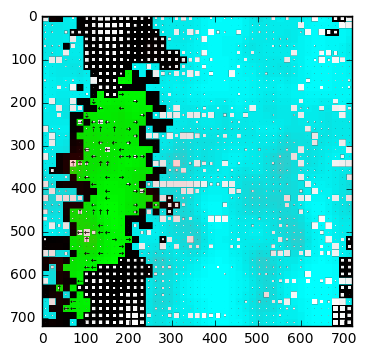

In [300]:
step = 225
frame = get_frames(replay)[step]
moves = np.array(replay['moves'])
is_player = frames[:,:,:,0]==1
filtered_moves = np.where(is_player[:-1],moves,np.zeros_like(moves))

state = {
    'colors':frame[:,:,0],
    'heat':frame[:,:,2],
    'squares':frame[:,:,1],
    'arrows':filtered_moves[step]
}

ims = plot_ims(state)

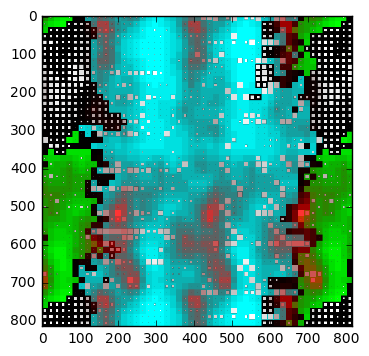

In [301]:
new_frame = center_frame(frame,get_centroid(frame,3),wrap_size=(50,50))

state = {
    'colors':new_frame[:,:,0],
    'heat':new_frame[:,:,2],
    'squares':new_frame[:,:,1],
}

ims = plot_ims(state)

In [66]:
new_frame.shape

(29, 29, 3)

In [67]:
frame.shape

(14, 14, 3)

In [29]:
import math

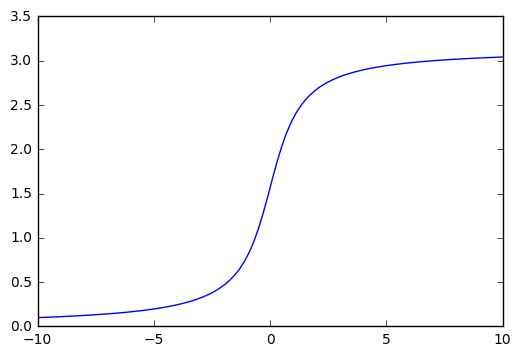

In [128]:
X = np.linspace(-10,10,100)
Y = [math.atan(x)+math.pi/2. for x in X]
plt.plot(X,Y)

In [37]:
math.atan(math.pi/2)

1.0038848218538872

In [69]:
get_centroid(frame,1)

(14.0, 12.0)

In [167]:
math.atan2?

In [61]:
get_centroid_1D([1,2,27,27,28],30)

29.0

In [63]:
player_tiles = frame[:,:,0]==1

In [65]:
np.where(frame[:,:,0]==1)

(array([6, 6, 7, 7, 7, 7, 8]), array([5, 6, 3, 4, 5, 6, 4]))

In [64]:
player_tiles

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False],
       [False, False, False, False, False,  True,  True, False, False,
        False, False, False, False, False],
       [False, False, False,  True,  True,  True,  True, False, False,
        False, False, False, False, False],
       [False, False, False, False,  True, False, False, False, False,
        F

In [268]:
moves = np.array(replay['moves'])

In [254]:
frames = get_frames(replay)

In [270]:
frames.shape

(241, 45, 45, 3)

In [269]:
moves.shape

(240, 45, 45)

In [290]:
np.sum(frames[200,:,:,0]==3)

1092

In [292]:
is_player = frames[:,:,:,0]==3

In [293]:
is_player.shape

np.where(is_player[:-1],moves,np.zeros_like(moves))

(241, 45, 45)

In [302]:
moves = np.array(replay['moves'])

In [310]:
is_player = frames[:,:,:,0]==3
filtered_moves = np.where(is_player[:-1],moves,np.zeros_like(moves))

In [311]:
np.sum(filtered_moves==0)/float(np.size(filtered_moves))

0.93124897119341565